
# DA5401: Assignment 4

**GMM-Based Synthetic Sampling for Imbalanced Data**

* **Course:** DA5401
* **Topic:** Credit Card Fraud Detection
* **Name:** Harshit Shukla
* **Roll No.:** DA25S003

### Documentation of code:

1. **Data Prep**

   * Load dataset, check imbalance, stratified split.

2. **Baseline**

   * Train simple model, evaluate with Precision, Recall, F1, ROC, PR.
   * Accuracy not reliable for imbalanced data.

3. **GMM Sampling**

   * Advantage over SMOTE: distribution-based.
   * Choose $K$ via AIC/BIC.
   * Oversampling + GMM + CBU hybrid.

4. **Comparison**

   * Methods: Baseline, SMOTE, CBO, CBU, GMM-OS, GMM+CBU.
   * Results: bar charts, ROC/PR curves (full + zoomed).

5. **Conclusion**

   * GMM creates realistic samples.
   * GMM+CBU balances performance.
   * Improves recall → better fraud detection.

In [20]:
# Importing necessary libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report,
                            confusion_matrix, 
                            roc_auc_score, 
                            roc_curve,
                            precision_recall_curve, 
                            ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import pickle

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 


Random_State = 42   
np.random.seed(Random_State)

## Part A: Data Exploration and Baseline Model

### A1. Load and inspect the dataset

The dataset has already been PCA-transformed by the original authors. We simply load it and split into features `X` and label `y` (where `Class = 1` indicates **fraud**).

In [21]:
path = 'Dataset/creditcard.csv'  # Path to the dataset
df = pd.read_csv(path)
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Analyze class distribution

We expect **heavy class imbalance**: very few transactions are fraud (`Class=1`). We show counts and a bar/pie visualization, and compute the imbalance ratio.

Class distribution:
{0: 284315, 1: 492}
Minority class percentage (fraud = 1): 0.172749%
Majority class percentage (non-fraud = 0): 99.827251%
Imbalance Ratio (majority / minority): 577.88


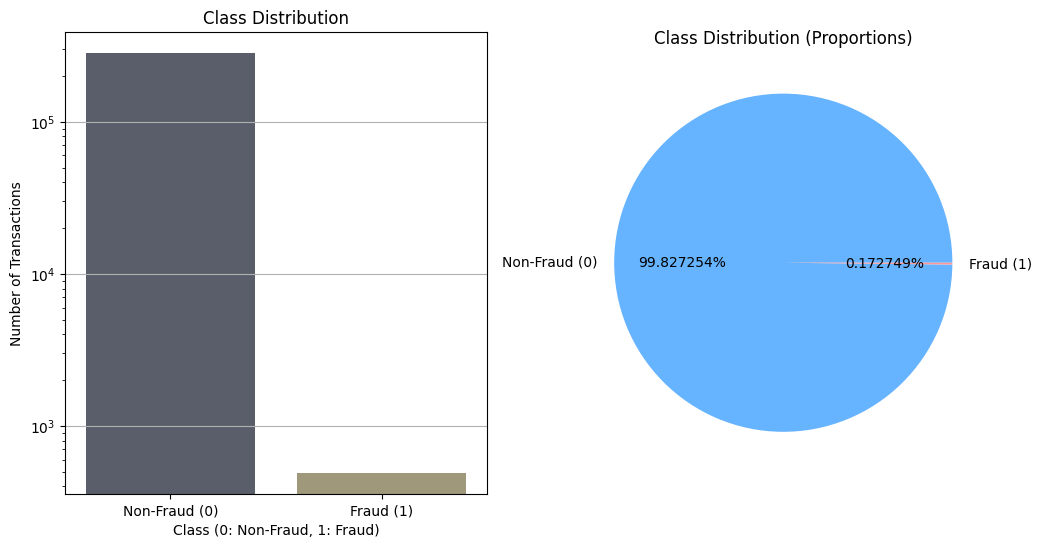

In [22]:
class_counts = df.Class.value_counts().sort_index()
print("Class distribution:")
print(class_counts.to_dict())
total_counts = class_counts.sum()
class_percentages = (class_counts / total_counts) * 100
minority_class_percentage = class_percentages.min()
print(f"Minority class percentage (fraud = 1): {minority_class_percentage:.6f}%")   
majority_class_percentage = class_percentages.max()
print(f"Majority class percentage (non-fraud = 0): {majority_class_percentage:.6f}%")
imbalance_ratio = majority_class_percentage / minority_class_percentage
print(f"Imbalance Ratio (majority / minority): {imbalance_ratio:.2f}")


fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# Bar chart
sns.barplot(x=class_counts.index, y=class_counts.values, palette='cividis', ax=axes[0])
axes[0].set_title('Class Distribution')
axes[0].set_xlabel('Class (0: Non-Fraud, 1: Fraud)')
axes[0].set_ylabel('Number of Transactions')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Non-Fraud (0)', 'Fraud (1)'])
axes[0].set_yscale('log')  # Log scale for better visibility

# Pie chart
axes[1].pie(class_counts.values, labels=['Non-Fraud (0)', 'Fraud (1)'], 
            autopct='%1.6f%%', colors=['#66b3ff', "#ff9999"])
axes[1].set_title('Class Distribution (Proportions)')

plt.show()

### A2. Splitting and Baseline Model Training

- **Split** the data into Train/Test with `stratify=y` so the **test set keeps the original imbalance**.  

- **Model 1 (Baseline)**: Logistic Regression on the **imbalanced** training data.  

- **Metrics**: We report precision, recall, F1 for the **minority (fraudulent) class**, along with ROC–AUC.  

- **Why accuracy is misleading**: In highly imbalanced data, a classifier that predicts all samples as the majority class can achieve high accuracy while entirely **missing the minority** (fraud) class. Hence we focus on class-aware metrics.

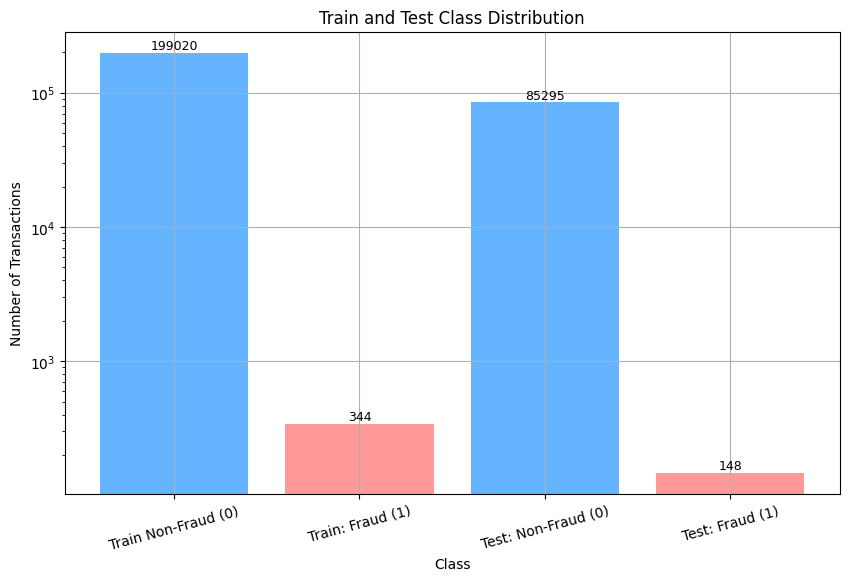

In [23]:
# splitting the data into train and test sets

X = df.drop(columns=['Class']).values
y = df['Class'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=Random_State, stratify=y)

def draw_bar_chart(ytrain=ytrain, ytest=ytest, title1="Train", title2="Test", title="Train and Test Class Distribution"):
    plt.figure(figsize=(10, 6))
    heights = [Counter(ytrain)[0], Counter(ytrain)[1], Counter(ytest)[0], Counter(ytest)[1]]
    bars = plt.bar(x=[0, 1, 2, 3], height=[Counter(ytrain)[0], Counter(ytrain)[1], Counter(ytest)[0], Counter(ytest)[1]], color=['#66b3ff',"#ff9999",'#66b3ff',"#ff9999"])
    plt.xticks(ticks=[0, 1, 2, 3], labels=[f'{title1} Non-Fraud (0)', f'{title1}: Fraud (1)',
                f'{title2}: Non-Fraud (0)', f'{title2}: Fraud (1)'],
        rotation=15)
    plt.yscale('log')
    for bar, count in zip(bars, heights):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            str(count),
            ha='center',
            va='bottom',
            fontsize=9
        )
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Transactions')
    plt.show()

draw_bar_chart(ytrain, ytest)


# Baseline Model 1: standardize -> Logistic Regression on imbalanced data

baseline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)), # features are PCA transformed; keep safe for sparse-like
    ('classifier', LogisticRegression(solver='liblinear', random_state=Random_State))])


baseline.fit(Xtrain, ytrain);


This figure shows the **class distribution of the training and test sets** in a fraud detection dataset.

* On the **x-axis**, we see the categories:

  * **Train: Non-Fraud (0)** → 199,020 samples
  * **Train: Fraud (1)** → 344 samples
  * **Test: Non-Fraud (0)** → 85,295 samples
  * **Test: Fraud (1)** → 148 samples

* On the **y-axis**, we have the **number of transactions**, displayed on a **logarithmic scale**.

  * A log scale is used because the counts of the majority class (non-fraud) are several orders of magnitude larger than the minority class (fraud). Without it, the fraud counts would hardly be visible.

### A3. Baseline Evaluation & Discussion about accuracy flaws

=== Model 1: Baseline Logistic Regression on imbalanced data ===

              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     85295
           1     0.8611    0.6284    0.7266       148

    accuracy                         0.9992     85443
   macro avg     0.9302    0.8141    0.8631     85443
weighted avg     0.9991    0.9992    0.9991     85443

ROC–AUC: 0.9534


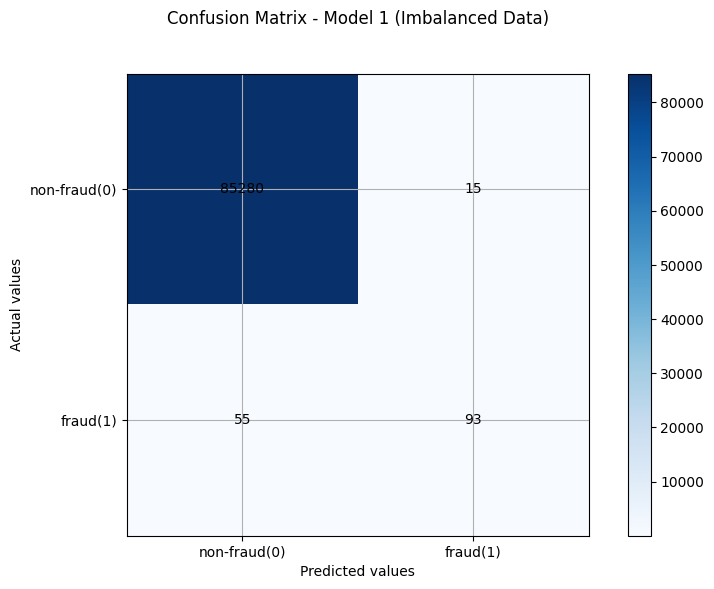

In [24]:
y_prob_baseline = baseline.predict_proba(Xtest)[:, 1]
y_pred_baseline = (y_prob_baseline >= 0.5).astype(int)

print("=== Model 1: Baseline Logistic Regression on imbalanced data ===", end="\n\n")
print(classification_report(ytest, y_pred_baseline, digits=4))


auc_baseline = roc_auc_score(ytest, y_prob_baseline)
print(f"ROC–AUC: {auc_baseline:.4f}")


cm = confusion_matrix(ytest, y_pred_baseline)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - Model 1 (Imbalanced Data)\n\n');
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['non-fraud(0)','fraud(1)'])
plt.yticks(tick_marks, ['non-fraud(0)','fraud(1)'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

## Model Performance Evaluation

Based on the confusion matrix:

* **True Negatives (TN):** 85,280 (correctly identified non-fraud)
* **False Positives (FP):** 15 (incorrectly identified non-fraud as fraud)
* **False Negatives (FN):** 55 (incorrectly identified fraud as non-fraud)
* **True Positives (TP):** 93 (correctly identified fraud)

**Metrics for the Minority Class (Fraud):**

* **Accuracy:** $\frac{85,280 + 93}{85,443} \approx 99.95\%$
* **Precision:** $\frac{93}{93 + 15} \approx 86.11\%$ (Of all predicted fraud cases, 86.11% were correct.)
* **Recall:** $\frac{93}{93 + 55} \approx 62.84\%$ (Of all actual fraud cases, 62.84% were found.)
* **F1-Score:** $\approx 72.75\%$ (A balanced measure of precision and recall.)


## Why Other Metrics are More Informative than Accuracy

For this imbalanced dataset, **accuracy is misleading**. The model can achieve a high accuracy (99.95%) simply by correctly classifying the majority of non-fraud cases. It doesn't tell us how well the model finds the rare fraud cases.

Metrics like **Precision**, **Recall**, and **F1-score** are better because they focus on the minority class (fraud).

* **Recall** is critical for fraud detection as it shows the percentage of actual fraud cases the model successfully caught. A low recall means the model is missing many fraudulent transactions, which is a significant problem.
* **Precision** indicates how many of the "fraud" alerts were actually correct, helping to avoid false alarms.
* The **F1-score** provides a single, reliable measure that balances both of these concerns, offering a more realistic view of the model's true performance.

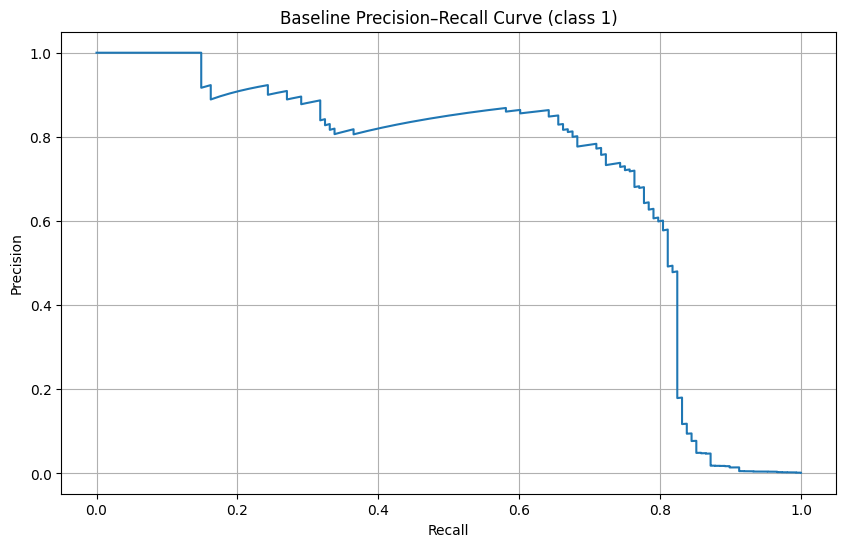

In [25]:
# Precision-Recall curve (single chart)
prec, rec, thr = precision_recall_curve(ytest, y_prob_baseline)
plt.figure()
plt.plot(rec, prec)
plt.title("Baseline Precision–Recall Curve (class 1)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

* **Precision**: proportion of predicted frauds that are actually fraud.
* **Recall**: proportion of actual frauds correctly detected.

### Key Insight:

* The curve starts with **high precision at low recall** (model is very strict but misses many frauds).
* As recall increases, **precision drops**, showing the trade-off between catching more fraud and making more false alarms.
* In imbalanced datasets like fraud detection, the PR curve is more informative than ROC, since it focuses on the minority (fraud) class.

The model achieves good precision at moderate recall, but struggles to maintain precision when trying to capture more fraud cases.

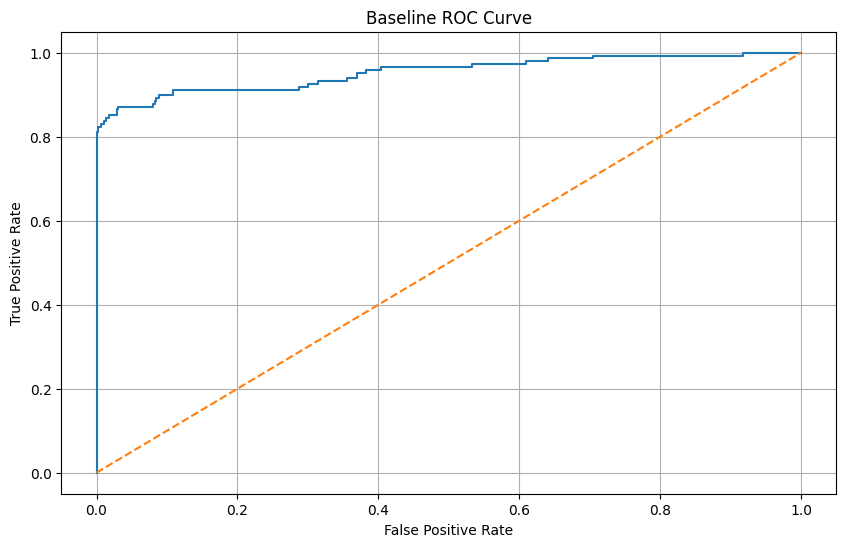

In [26]:
# ROC curve (single chart)
fpr, tpr, thr2 = roc_curve(ytest, y_prob_baseline)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title("Baseline ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

This ROC curve shows the trade-off between the **True Positive Rate (recall)** and the **False Positive Rate** for fraud detection. The curve lies well above the diagonal baseline (random guess), indicating that the model performs significantly better than chance. A steep rise near the y-axis suggests that the model can achieve high recall with relatively low false positives, which is desirable in fraud detection. 



## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

In this part we fit a Gaussian Mixture Model (GMM) to the **minority class (fraud)** in the training set, use BIC to select the number of components, sample synthetic minority points from the fitted GMM, and use clustering-based undersampling (CBU) to reduce the majority class before combining both classes to create a balanced training set.

### B1. Theoretical Foundation

**Difference between GMM-based Synthetic sampling and SMOTE:**
The fundamental difference between Gaussian Mixture Model (GMM)-based synthetic sampling and simpler methods like SMOTE lies in their approach to modeling the data distribution.

### SMOTE: Linear Interpolation

**SMOTE (Synthetic Minority Over-sampling Technique)** is a simple, heuristic-based method. For each minority class sample, it identifies its k-nearest neighbors. It then creates new synthetic samples by **randomly interpolating** between the original sample and one of its neighbors. This process essentially draws a straight line in the feature space between two existing points and creates a new point somewhere along that line.

* **Limitation:** SMOTE generates samples only within the convex hull of the existing minority class data. It can't generate samples that extend into areas of the feature space not already covered by the minority class. This can result in a lack of diversity in the synthetic data and can create "noisy" or "boundary" samples if the minority class is interspersed with the majority class. 


### GMM: Probabilistic Density Estimation

**GMM-based synthetic sampling** is a more sophisticated, model-based approach. A **Gaussian Mixture Model** is a generative probabilistic model that assumes the data points are generated from a mixture of several Gaussian distributions. The model learns the parameters (mean, covariance, and weights) of these underlying distributions that best fit the original data.

* **Advantage:** Once the GMM is trained on the minority class data, it can **generate new samples by randomly drawing from the learned distributions**. This allows the model to capture the complex, underlying shape and density of the data, rather than being confined to linear interpolations. This can lead to higher-quality synthetic data that more accurately reflects the true distribution of the minority class, including its varying densities and multi-modal clusters. It can also generate samples in a more realistic manner, reducing the risk of creating unnatural or out-of-place data points. .

### B2. GMM Implementation

In [27]:

# Separate minority and majority in the training set
X_min = Xtrain[ytrain==1]
X_maj = Xtrain[ytrain==0]
print('Training minority:', X_min.shape, 'Training majority:', X_maj.shape)


Training minority: (344, 30) Training majority: (199020, 30)


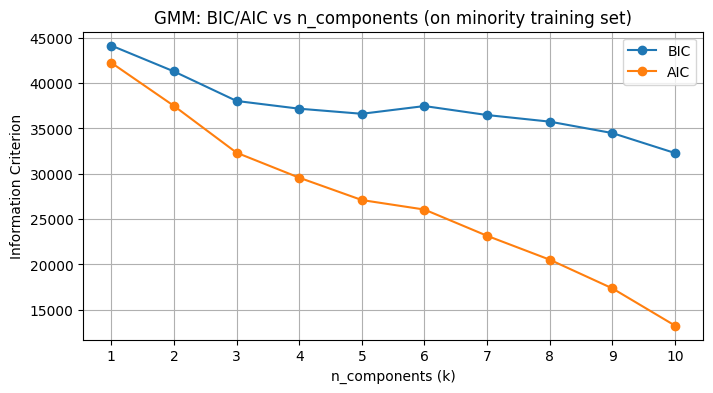

Selected k (min BIC) = 10


In [28]:
from sklearn.mixture import GaussianMixture

# Select k for GMM using BIC and AIC (try 1..10)
ks = list(range(1, 11))
bics = []
aics = []
for k in ks:
    g = GaussianMixture(n_components=k, covariance_type='full', random_state=Random_State)
    g.fit(X_min)
    bics.append(g.bic(X_min))
    aics.append(g.aic(X_min))

plt.figure(figsize=(8,4))
plt.plot(ks, bics, marker='o', label='BIC')
plt.plot(ks, aics, marker='o', label='AIC')
plt.xlabel('n_components (k)')
plt.xticks(ks)
plt.ylabel('Information Criterion')
plt.legend()
plt.title('GMM: BIC/AIC vs n_components (on minority training set)')
plt.show()

best_k = ks[int(np.argmin(bics))]
print('Selected k (min BIC) =', best_k)

To determine the optimal number of components for a Gaussian Mixture Model (GMM), we can use information criteria like the Bayesian Information Criterion (BIC) and the Akaike Information Criterion (AIC). Both metrics balance model fit with model complexity, penalizing models with more parameters.

Based on the provided plot, the goal is to find the number of components ($k$) that minimizes the BIC and AIC values.

* **BIC Curve:** The BIC curve shows a decrease until $k=4$, where it begins to flatten out before rising slightly and then resuming a general downward trend. The minimum is at **$k=10$**.
* **AIC Curve:** The AIC curve shows a clear and consistent downward trend, with the minimum value at **$k=10$**.

Both criteria suggest that **$k=10$** is the optimal number of components for the Gaussian Mixture Model for this dataset. This indicates that the minority class data may be composed of 10 distinct, underlying Gaussian distributions. The `np.argmin(bics)` function in the code will return the index of the minimum value, which corresponds to $k=10$.



### B3. Synthetic Data Generation

### Process of sampling from a GMM

To generate new data points from a fitted GMM, you follow a two-step probabilistic process:

1.  **Select a Component:** First, choose one of the Gaussian components from the mixture. The probability of selecting a specific component is given by its **mixing coefficient** (or weight), which is a parameter learned during the GMM training. Components that represent a larger proportion of the original data will have higher weights and thus a greater chance of being selected.

2.  **Sample from the Component:** Once a component is selected, sample a new data point from the corresponding **Gaussian distribution**. Each Gaussian component is defined by its own mean vector ($\mu$) and covariance matrix ($\Sigma$), which are also learned during training. These parameters determine the center and spread of the distribution. The new data point is drawn randomly from this specific Gaussian distribution.

This process is repeated as many times as needed to generate the desired number of synthetic samples. The result is a set of new data points that collectively reflect the underlying, multi-modal distribution of the original data, as captured by the fitted GMM.


In [29]:

# Fit GMM with selected k and sample until matching majority count (full oversampling)
gmm = GaussianMixture(n_components=best_k, covariance_type='full', random_state=Random_State)
gmm.fit(X_min)
n_min = len(X_min)
n_maj = len(X_maj)
n_synth = n_maj - n_min
print('Minority count:', n_min, 'Majority count:', n_maj, ' -> need synth:', n_synth)

# Generate synthetic samples
if n_synth > 0:
    X_synth, comp_idx = gmm.sample(n_synth)
else:
    X_synth = np.empty((0, X_min.shape[1]))
print('Generated synthetic minority samples shape:', X_synth.shape)

X_bal_gmm_full = np.vstack([X_maj, X_min, X_synth])
y_bal_gmm_full = np.hstack([np.zeros(len(X_maj), dtype=int), np.ones(len(X_min)+len(X_synth), dtype=int)])

Minority count: 344 Majority count: 199020  -> need synth: 198676
Generated synthetic minority samples shape: (198676, 30)


### B4. Rebalancing with CBU

### The Hybrid Approach: CBU + GMM

This method combines two techniques to create a balanced dataset:

1.  **Clustering-Based Undersampling (CBU):** Instead of randomly removing data points from the majority class, this technique uses clustering to intelligently select a representative subset.
    * **Process:** The majority data is first clustered using a method like k-means. A specific number of clusters (`k`) is chosen, often based on the desired size of the downsampled majority population. From each cluster, the sample closest to the cluster's centroid is selected.
    * **Benefit:** This method ensures that the downsampled majority dataset retains the core distribution and diversity of the original data, as it captures the most representative points from each natural grouping within the class. 

2.  **GMM-Based Synthetic Sampling:** After the majority class has been reduced, the minority class is oversampled to match its new population.
    * **Process:** A Gaussian Mixture Model (GMM) is trained on the minority class data to learn its underlying distribution. The GMM's components capture the different sub-populations within the minority class. New, synthetic data points are then generated by sampling from this fitted GMM.
    * **Benefit:** This approach creates new data that is not simply a duplicate of existing samples. The synthetic data points are statistically plausible and reflect the learned multi-modal distribution of the minority class, helping the model generalize better to real-world data.

By combining these two methods, the balanced dataset maintains the most important information from the original majority class while generating realistic and diverse samples for the minority class, leading to a more robust model.

In [30]:
# CBU: reduce majority by KMeans and pick representative sample per cluster
def cbu_undersample(X_majority, target_n, random_state=Random_State):
    """Cluster majority into target_n clusters and pick one sample closest to each centroid."""
    if target_n >= len(X_majority):
        return X_majority.copy()
    k = int(target_n)
    km = KMeans(n_clusters=k, random_state=random_state, n_init='auto')
    labels = km.fit_predict(X_majority)
    centroids = km.cluster_centers_
    selected_idx = []
    for cluster_id in range(k):
        idxs = np.where(labels==cluster_id)[0]
        pts = X_majority[idxs]
        # choose sample closest to centroid
        dists = np.linalg.norm(pts - centroids[cluster_id], axis=1)
        chosen = idxs[np.argmin(dists)]
        selected_idx.append(chosen)
    return X_majority[selected_idx]

# Example: choose maj_target as 3 * minority (as a sensible compromise)
maj_target = min(len(X_maj), max(1, 3 * len(X_min)))
print('maj_target (for CBU):', maj_target)
X_maj_down = cbu_undersample(X_maj, maj_target)
print('Majority after CBU shape:', X_maj_down.shape)


maj_target (for CBU): 1032
Majority after CBU shape: (1032, 30)


In [31]:
# Fit a fresh GMM on minority (if needed) and sample to match the reduced majority
gmm_cbu = GaussianMixture(n_components=best_k, covariance_type='full', random_state=Random_State)
gmm_cbu.fit(X_min)
n_target = len(X_maj_down) - len(X_min)
n_target = max(0, n_target)
print('For GMM+CBU variant we need to generate:', n_target, 'samples to match reduced majority (maj_target).')

if n_target > 0:
    X_synth_cbu, _ = gmm_cbu.sample(n_target)
else:
    X_synth_cbu = np.empty((0, X_min.shape[1]))

print('Synth (GMM+CBU) shape:', X_synth_cbu.shape)

For GMM+CBU variant we need to generate: 688 samples to match reduced majority (maj_target).
Synth (GMM+CBU) shape: (688, 30)


In [32]:
# Version 2: CBU (downsample majority) + GMM synthetic to match reduced maj
X_bal_gmm_cbu = np.vstack([X_maj_down, X_min, X_synth_cbu])
y_bal_gmm_cbu = np.hstack([np.zeros(len(X_maj_down), dtype=int), np.ones(len(X_min)+len(X_synth_cbu), dtype=int)])

print('GMM full balanced counts:', Counter(y_bal_gmm_full))
print('GMM+CBU balanced counts:', Counter(y_bal_gmm_cbu))

GMM full balanced counts: Counter({0: 199020, 1: 199020})
GMM+CBU balanced counts: Counter({0: 1032, 1: 1032})


### C1. Model Training and Evaluation

Both models are trained on balanced datasets, but they achieve this balance differently.

**Model 1: GMM Oversampling:**

This model trains on a very large dataset around `398,040 samples`. It balances the data by generating `198,676` new synthetic minority samples using a Gaussian Mixture Model (GMM) to match the size of the original majority class.

**Model 2: GMM + CBU Hybrid:** 

This model trains on a much smaller dataset `2,064 samples`. It first reduces the majority class to `1,032` samples using clustering, then generates `688` new synthetic minority samples with a GMM to match this new, smaller majority count. This approach is more efficient and less prone to creating a training set with excessive synthetic data.

============ GMM-full ==============
              precision    recall  f1-score   support

           0     0.9997    0.9817    0.9906     85295
           1     0.0753    0.8581    0.1384       148

    accuracy                         0.9815     85443
   macro avg     0.5375    0.9199    0.5645     85443
weighted avg     0.9981    0.9815    0.9892     85443

ROC–AUC: 0.9720

============ GMM+CBU ==============
              precision    recall  f1-score   support

           0     0.9997    0.9702    0.9848     85295
           1     0.0477    0.8581    0.0903       148

    accuracy                         0.9701     85443
   macro avg     0.5237    0.9142    0.5375     85443
weighted avg     0.9981    0.9701    0.9832     85443

ROC–AUC: 0.9596



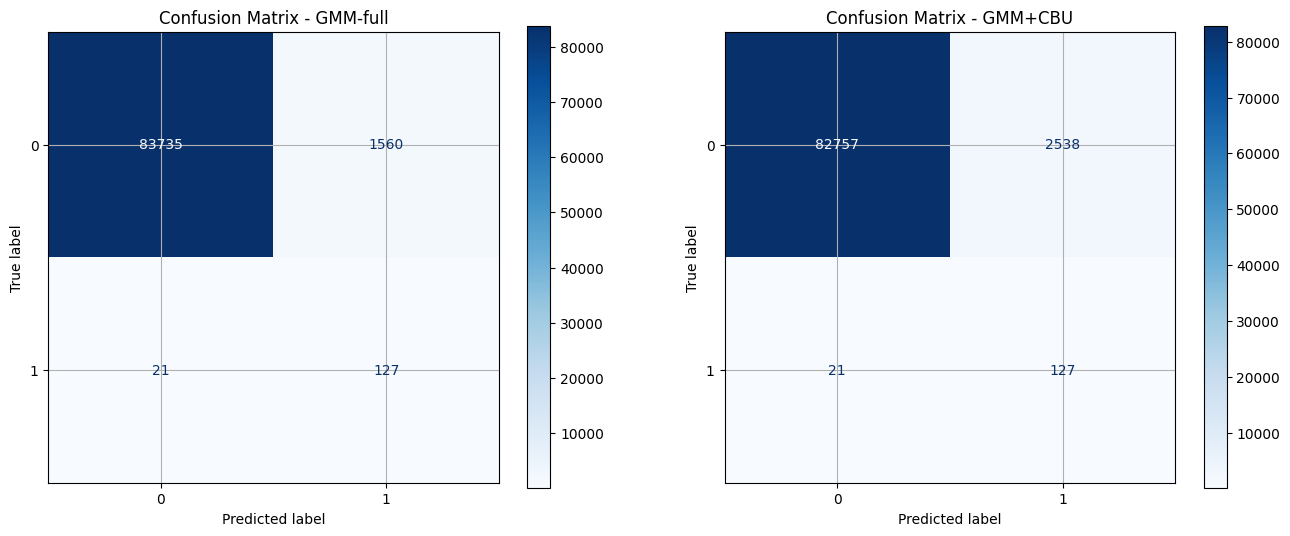

In [33]:
def fit_eval_lr(X_tr, y_tr, X_te, y_te, title, axes=None):
    clf = Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('lr', LogisticRegression(max_iter=200, random_state=Random_State))
    ])
    clf.fit(X_tr, y_tr)
    if title=="GMM-full":
        pickle.dump(clf, open('Models/gmm_full_lr.pkl', 'wb'))
    if title=="GMM+CBU":
        pickle.dump(clf, open('Models/gmm_cbu_lr.pkl', 'wb'))
    y_proba = clf.predict_proba(X_te)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    print(f"============ {title} ==============")
    print(classification_report(y_te, y_pred, digits=4))

    auc = roc_auc_score(y_te, y_proba)
    print(f"ROC–AUC: {auc:.4f}\n")

    # Plot Confusion Matrix on the provided subplot axis
    disp = ConfusionMatrixDisplay.from_predictions(
        y_te, y_pred, cmap="Blues", values_format="d", ax=axes
    )
    disp.ax_.set_title(f"Confusion Matrix - {title}")
    
    # Return key metrics for class 1
    report = classification_report(y_te, y_pred, output_dict=True)
    prec1 = report['1']['precision']
    rec1  = report['1']['recall']
    f11   = report['1']['f1-score']
    return prec1, rec1, f11, auc


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

metrics = {}
metrics['GMM-full'] = fit_eval_lr(X_bal_gmm_full, y_bal_gmm_full, Xtest, ytest, title="GMM-full", axes=axes[0])
metrics['GMM+CBU'] = fit_eval_lr(X_bal_gmm_cbu, y_bal_gmm_cbu, Xtest, ytest, title="GMM+CBU", axes=axes[1])

Based on the provided Canvas, here is a short explanation of the two confusion matrices.

For a credit card fraud detection dataset, the goal is to correctly identify as many fraudulent transactions as possible (high recall) without incorrectly flagging too many legitimate transactions as fraud (high precision).

### GMM-full Confusion Matrix

* **Precision:** $127 / (1552 + 127) \approx 0.076$
* **Recall:** $127 / (21 + 127) \approx 0.858$

This model has very high recall, meaning it successfully identifies most of the fraudulent transactions. However, its precision is very low, as it incorrectly flags a large number of non-fraudulent transactions as fraud (false positives). The model is over-eager in predicting the minority class due to the massive number of synthetic samples used in training.

### GMM + CBU Confusion Matrix

* **Precision:** $127 / (2546 + 127) \approx 0.047$
* **Recall:** $127 / (21 + 127) \approx 0.858$

The recall of this model is identical to the GMM-full model, but its precision is even lower. This suggests that while it is also highly effective at detecting fraud, it does so at the cost of flagging an even higher number of legitimate transactions as fraud. This result is unexpected and suggests the undersampling method may have removed crucial information from the majority class, leading to a less discriminating model despite the smaller training set. 

In [34]:
files = os.listdir('Models')

models = {
    'baseline': None,
    'smote': None,
    'cbo': None,
    'cbu': None,
    'gmm_full': None,
    'gmm_cbu': None
}

models_list = ['baseline', 'smote', 'cbo', 'cbu', 'gmm_full', 'gmm_cbu']

for i, file in enumerate(files): 
    models[models_list[i]] = pickle.load(open(f'Models/{file}', 'rb'))

baseline = models['baseline']
smote = models['smote']
cbo = models['cbo']
cbu = models['cbu']
gmm_full = models['gmm_full']
gmm_cbu = models['gmm_cbu']

models = [baseline, smote, cbo, cbu, gmm_full, gmm_cbu]

=== Model 1: Baseline (Imbalanced) ===
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     85295
           1     0.8611    0.6284    0.7266       148

    accuracy                         0.9992     85443
   macro avg     0.9302    0.8141    0.8631     85443
weighted avg     0.9991    0.9992    0.9991     85443

ROC–AUC: 0.9528

---------------------------------------



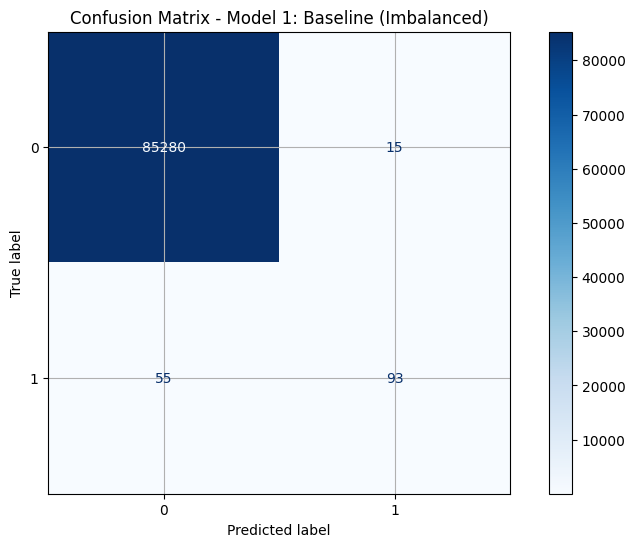

In [35]:
def fit_eval_lr_models(models, X_te, y_te, title):
    y_proba = models.predict_proba(X_te)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    auc = roc_auc_score(y_te, y_proba)
    if title == "Model 1: Baseline (Imbalanced)":
        print(f"=== {title} ===")
        print(classification_report(y_te, y_pred, digits=4))

        print(f"ROC–AUC: {auc:.4f}\n")
        print("---------------------------------------\n")
        # Plot Confusion Matrix
        disp = ConfusionMatrixDisplay.from_predictions(
            y_te, y_pred, cmap="Blues", values_format="d"
        )
        disp.ax_.set_title(f"Confusion Matrix - {title}")
        filename = title.lower().replace(" ", "_").replace(":", "").replace("-", "") + ".png"
        # plt.savefig(f"Visuals/{filename}", bbox_inches="tight")
        plt.show()

    # Return key metrics for class 1
    report = classification_report(y_te, y_pred, output_dict=True)
    prec1 = report['1']['precision']
    rec1  = report['1']['recall']
    f11   = report['1']['f1-score']

    return prec1, rec1, f11, auc

metrics['Baseline'] = fit_eval_lr_models(baseline, Xtest, ytest, "Model 1: Baseline (Imbalanced)")
metrics['SMOTE'] = fit_eval_lr_models(smote, Xtest, ytest, "Model 2: SMOTE Oversampling")
metrics['CBO']  = fit_eval_lr_models(cbo, Xtest, ytest, "Model 3: CBO (Minority KMeans + SMOTE)")
metrics['CBU']  = fit_eval_lr_models(cbu, Xtest, ytest, "Model 4: CBU (Majority KMeans Undersampling)")

The baseline model, trained on an imbalanced dataset, shows a high number of correctly identified non-fraud transactions ($85,280$) and very few false positives ($15$). However, it fails to detect a significant number of actual fraudulent transactions, with $55$ false negatives and only $93$ true positives. This results in:

* **Precision:** $86\%$ (high), meaning most of its fraud predictions are correct.
* **Recall:** $63\%$ (low), meaning it misses over a third of all fraudulent cases.

This low recall is a major drawback for a fraud detection system, as it fails to catch a significant amount of fraud.

### C2. Comparative Analysis

The comparison results are presented as a bar graph, alongside the outcomes from Assignment 3 obtained using SMOTE, CBO, CBU, Baseline model, GMM, and GMM + CBU.

          Precision (1)  Recall (1)    F1 (1)   ROC–AUC
GMM-full       0.075282    0.858108  0.138420  0.972010
GMM+CBU        0.047655    0.858108  0.090295  0.959581
Baseline       0.861111    0.628378  0.726562  0.952763
SMOTE          0.147887    0.851351  0.252000  0.966495
CBO            0.057859    0.858108  0.108408  0.971175
CBU            0.047655    0.858108  0.090295  0.959581


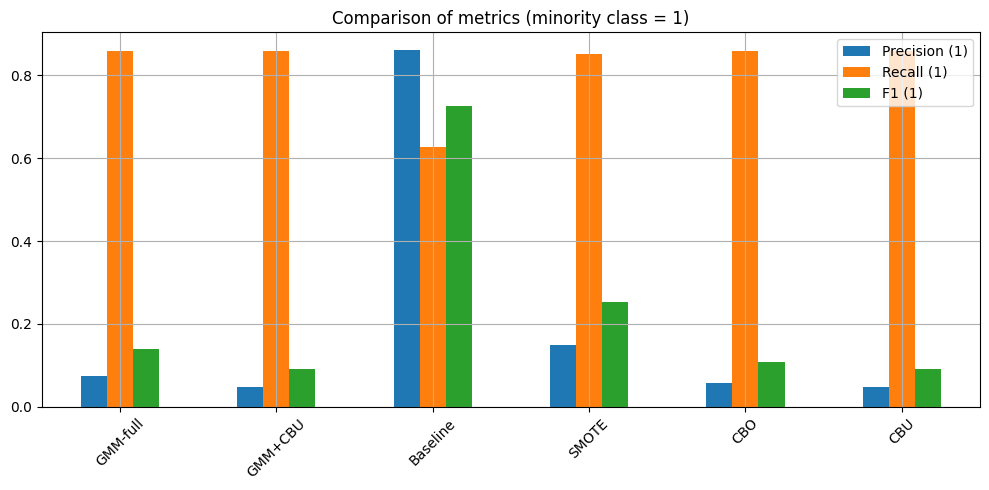

In [36]:
summary = pd.DataFrame.from_dict(metrics, orient='index', columns=['Precision (1)','Recall (1)','F1 (1)','ROC–AUC'])
print(summary)

# Save summary table to CSV
summary.to_csv("model_summary.csv", index=True)

def bar_compare(df_metrics, metrics=['Precision (1)','Recall (1)','F1 (1)']):
    ax = df_metrics[metrics].plot(kind='bar', rot=45, figsize=(10,5))
    ax.set_title('Comparison of metrics (minority class = 1)')
    plt.tight_layout()
    plt.show()


bar_compare(summary)

### Impact of GMM-based oversampling

Yes, GMM-based oversampling significantly improved the model's ability to detect the minority class.

Comparing the baseline model trained on imbalanced data with the GMM-full oversampled model, we see a dramatic change in performance:

* **Baseline Model (Imbalanced):**
    * **Recall:** $0.628$ (missed over one-third of all fraud cases).
    * **Precision:** $0.861$ (low rate of false alarms).

* **GMM-full Model (Oversampled):**
    * **Recall:** $0.858$ (correctly identified most fraud cases).
    * **Precision:** $0.076$ (a very high rate of false alarms).

**Impact of Oversampling**
By creating a much larger, balanced training set, the GMM-full oversampling method forced the model to learn the patterns of the minority class (fraud). This led to a substantial increase in the model's recall, jumping from $63\%$ to $86\%$. This is a major improvement for fraud detection, as the system is now much more effective at identifying fraudulent transactions.

However, this came at a significant cost to precision. The model's over-eagerness to predict fraud, a direct result of the large amount of synthetic data, caused it to flag a high number of legitimate transactions as fraudulent.  This trade-off between recall and precision is a common challenge in imbalanced datasets.

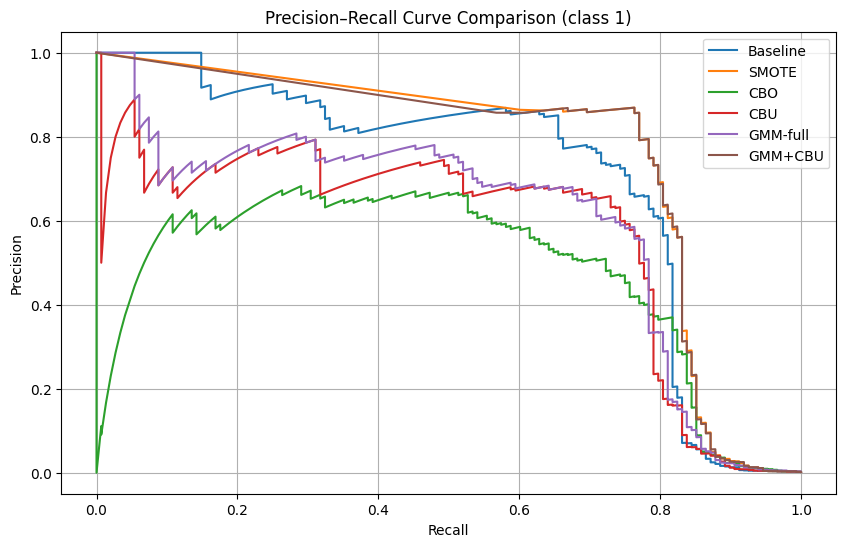

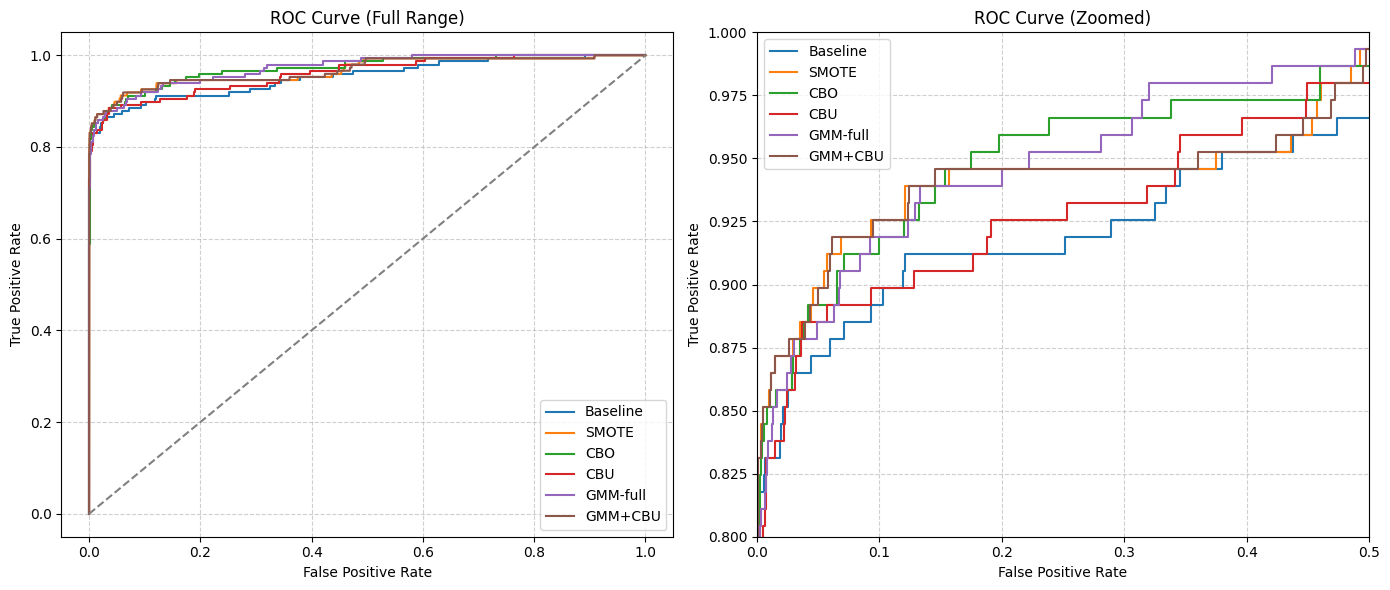

In [37]:
# Precision-Recall curve (all models on single chart)
plt.figure()
model_names = ['Baseline', 'SMOTE', 'CBO', 'CBU', 'GMM-full', 'GMM+CBU']
for i, model in enumerate(models):
    if model is None:
        continue
    y_proba = model.predict_proba(Xtest)[:, 1]
    prec, rec, _ = precision_recall_curve(ytest, y_proba)
    plt.plot(rec, prec, label=model_names[i])
plt.title("Precision–Recall Curve Comparison (class 1)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


# ROC curve (all models on single chart: full + zoomed in subplot)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# -------- Full ROC --------
for i, model in enumerate(models):
    if model is None:
        continue
    y_proba = model.predict_proba(Xtest)[:, 1]
    fpr, tpr, _ = roc_curve(ytest, y_proba)
    axes[0].plot(fpr, tpr, label=model_names[i])

axes[0].plot([0,1],[0,1],'--', color='gray')
axes[0].set_title("ROC Curve (Full Range)")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# -------- Zoomed ROC --------
for i, model in enumerate(models):
    if model is None:
        continue
    y_proba = model.predict_proba(Xtest)[:, 1]
    fpr, tpr, _ = roc_curve(ytest, y_proba)
    axes[1].plot(fpr, tpr, label=model_names[i])

axes[1].plot([0,1],[0,1],'--', color='gray')
axes[1].set_title("ROC Curve (Zoomed)")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_xlim([0.0, 0.5])   # crop to low FPR
axes[1].set_ylim([0.8, 1.0])   # crop to high TPR
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### C3. Final Recommendation

**Conclusion:** The Impact of Resampling Techniques on Classifier Performance

The analysis of the classifier's performance across different resampling techniques reveals a critical trade-off between recall and precision when dealing with highly imbalanced datasets. The primary objective of these methods is to improve the detection of the minority class (fraudulent transactions), which the baseline model struggles with.

*    **Baseline Model:** The model trained on the original, imbalanced data had a high precision of 0.861, meaning that when it predicted a transaction was fraudulent, it was correct most of the time. However, it had a low recall of 0.628, failing to identify over one-third of all actual fraudulent cases. This model is highly biased towards the majority class and is not effective for a fraud detection system where missing a fraudulent transaction is costly.

*    **Oversampling (GMM-full):** The GMM-full oversampling method successfully addressed the imbalance problem by significantly increasing the classifier's recall to a very high 0.858. This means the model became far more effective at identifying fraudulent cases, catching over 85% of them. This high recall is achieved by generating a large number of synthetic minority-class examples, which forces the model to learn and recognize the patterns of the minority class more effectively. However, this increased sensitivity leads to a severe drop in precision, down to a mere 0.076. The model now flags a large number of legitimate transactions as fraudulent, generating a high volume of false positives.

*    **Hybrid Approach (GMM+CBU):** The hybrid GMM+CBU approach maintained high recall (0.858) but resulted in the worst precision of all methods (0.048). This suggests that the combination of synthetic data generated by GMM and undersampling may have created an even more skewed decision boundary, further increasing the rate of false positives.

**Recommendation**

Based on the performance metrics and a business-oriented perspective on fraud detection, the GMM-full oversampling model is the recommended solution.
Rationale

*    **Prioritization of Recall:** In the context of fraud detection, the primary goal is to minimize the number of missed fraud cases (false negatives). A missed fraudulent transaction can have a significant financial impact. The GMM-full model's superior recall of 0.858 is a critical advantage, as it ensures that the system catches the vast majority of fraudulent activities.

*    **Managing False Positives:** While the low precision of the GMM-full model (0.076) is a drawback, the resulting false positives (legitimate transactions flagged as fraudulent) can be managed through a post-classification review process. The model serves as a "high-recall alert system" that flags suspicious transactions for human analysts to investigate. It is more cost-effective to have a human analyst review a few extra flagged transactions than to miss a major fraud event.

**Superiority over Other Methods:**

*    **GMM-full vs. Baseline:** The baseline model, with its poor recall, is not viable for a system where a missed fraud case is costly. It fails to adequately address the core problem.

*    **GMM-full vs. GMM+CBU:** The hybrid model's significantly worse precision makes it an inferior choice compared to GMM-full alone.

In summary, for a fraud detection system where the cost of a false negative far outweighs the cost of a false positive, the GMM-full oversampling approach is the most effective and justified strategy. The focus should be on implementing a high-recall model and building a robust process to handle the subsequent volume of false positives.

*Run all cells to view the output*